# THEANO tutorial

Tutorial available here : http://deeplearning.net/software/theano/tutorial/

## Baby Steps - Algebra

In [1]:
import theano.tensor as T
from theano import function

### Simple Algebra

In [5]:
# 1. Instantiate symbolic variables
x = T.vector(name="x")
y = T.vector(name="y")
# 2. Build a computation graph
z = x + y
# 3. Compile a callable function
f = function(inputs=[x, y], outputs=z)
# 4. Call the function using numerical inputs
print f([1, 2], [3, 4])

[ 4.  6.]


#### Type

x, y, and z are **TensorVariables** : not persistent across function calls.

In [9]:
type(z)

theano.tensor.var.TensorVariable

Symbolic variables have to be **typed** (vector here). If you give a scalar to the function, it won't work :

In [40]:
try:
    f(1.0,3.0)
except:
    print "Error"

Error


See http://deeplearning.net/software/theano/library/tensor/basic.html for more details about types

#### Pretty print

In [11]:
from theano import pp
pp(z)

'(x + y)'

#### Other function

In [16]:
z = 2*x + 3*(y**2) + 2
g = function(inputs=[x, y], outputs=z)

In [15]:
pp(z)

'(((TensorConstant{2} * x) + (TensorConstant{3} * (y ** TensorConstant{2}))) + TensorConstant{2})'

TensorConstant can't change.

Even if the graph has changed, if you don't compile f again, then f continues to output x + y

In [14]:
print f([1, 2], [3, 4])
print g([1, 2], [3, 4])

[ 4.  6.]
[ 31.  54.]


In [35]:
o = 3*z + 1
h = function(inputs=[x, y], outputs=o)

#### Other function

In [37]:
print pp(o)
print h([1.0],[3.0])

((TensorConstant{3} * (((TensorConstant{2} * x) + (TensorConstant{3} * (y ** TensorConstant{2}))) + TensorConstant{2})) + TensorConstant{1})
[ 94.]


## More Examples

### Logistic Regression

In [42]:
x = T.matrix('x')
s = 1 / (1 + T.exp(-x))
logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

array([[ 0.5       ,  0.7310586 ],
       [ 0.26894143,  0.11920292]], dtype=float32)

### Setting a Default Value for an Argument

In [44]:
from theano import Param
x, y = T.dscalars('x', 'y')
z = x + y
f = function([x, Param(y, default=1)], z)

print f(33)

34.0


### Using Shared Variables

In [45]:
from theano import shared

state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

**Shared Variables** are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions, but they always have an internal value that is kept in memory.

The other new thing in this code is the **updates parameter** of function. updates must be supplied with a list of pairs of the form (shared-variable, new expression).

In [50]:
print state.get_value()
accumulator(1)
print state.get_value()
accumulator(300)
print state.get_value()

0
1
301


The function returns "state" and increments after :

In [51]:
accumulator(-5)

array(301)

Reset :

In [53]:
state.set_value(0)

**givens** parameter allow you to skip the internal value of a shared value if you do not want to use it :

In [55]:
fn_of_state = state * 2 + inc
# The type of foo must match the shared variable we are replacing
# with the ``givens``
foo = T.scalar(dtype=state.dtype)
skip_shared = function([inc, foo], fn_of_state, givens=[(state, foo)])

array(0)

In [56]:
print skip_shared(1, 3)  # we're using 3 for the state, not state.value
print state.get_value()  # old state still there, but we didn't use it

7
0


### Random Numbers

In [78]:
from theano.tensor.shared_randomstreams import RandomStreams

srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
rv_n = srng.normal((2,2))
f = function([], rv_u)
g = function([], rv_n, no_default_updates=True)    #Not updating rv_n.rng
nearly_zeros = function([], rv_u + rv_u - 2 * rv_u)

In [83]:
print f()
print "With update :"
print f()

[[ 0.12672381  0.97091597]
 [ 0.13989098  0.88754827]]
With update :
[[ 0.31971416  0.47584376]
 [ 0.24129163  0.42046082]]


In [82]:
print g()
print "No update :"
print g()

[[ 0.37328446 -0.65746671]
 [-0.36302373 -0.97484624]]
No update :
[[ 0.37328446 -0.65746671]
 [-0.36302373 -0.97484624]]


In [85]:
print "Random variables are drawn at most once during any single function execution :"
nearly_zeros()

Random variables are drawn at most once during any single function execution :


array([[ 0.,  0.],
       [ 0.,  0.]], dtype=float32)

#### Seeding only one variable :

In [89]:
rng_val = rv_u.rng.get_value(borrow=True)   # Get the rng for rv_u
rng_val.seed(89234)                         # seeds the generator
rv_u.rng.set_value(rng_val, borrow=True)    # Assign back seeded rng

#### Seeding all variables :

In [90]:
srng.seed(902340)  # seeds rv_u and rv_n with different seeds each

### Gradient Computation

In [92]:
# 1. Instantiate symbolic variables
x = T.vector(name="x")
# 2. Build a computation graph
z = (x ** 2).sum()
d_z_d_x = T.grad(z, x)
# 3. Compile a callable function
f = function(inputs=[x], outputs=d_z_d_x)
# 4. Call the function using numerical inputs
print f([1, 2])

[ 2.  4.]


## Realistic examples : 

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

### Linear Regression

#### Generate data

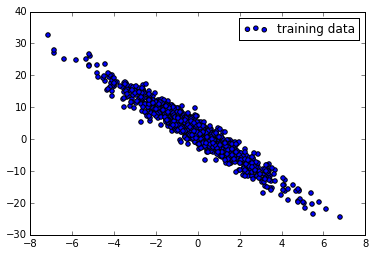

In [128]:
inputs = 2*np.random.randn(1000)
sigma = 2
targets = -4*inputs + 2 + sigma*np.random.randn(1000)

plt.figure()
plt.scatter(inputs,targets, label="training data")
plt.legend()
plt.show()

#### Theano model

In [118]:
x = T.scalar(name="x") # inputs
t = T.scalar(name="t") # targets

a = shared(-1.0, name="a") # slope
b = shared(0.0, name="b")  # y-intercept
y = a * x + b  # model
mse = (y - t) ** 2  # cost
grad_a, grad_b = T.grad(mse, [a, b])  # gradients

train = function(inputs=[x, t], outputs=mse, updates=((a, a - 0.01 * grad_a), (b, b - 0.01 * grad_b)))
test = function([x],outputs=y)

#### Training

In [129]:
for input_,target_ in zip(np.array(inputs, "float32"),np.array(targets,"float32")):
    train(input_,target_)

In [130]:
print a.get_value()
print b.get_value()

-3.74315401806
2.09352542446


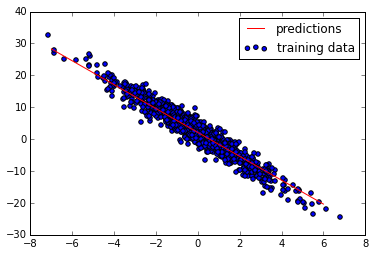

In [131]:
predictions = [test(i) for i in np.arange(-7,7,1)]

plt.figure()
plt.scatter(inputs,targets, label="training data")
plt.plot(np.arange(-7,7,1), predictions, c="r", label="predictions")
plt.legend()
plt.show()

### Logistic Regression

#### Generate data

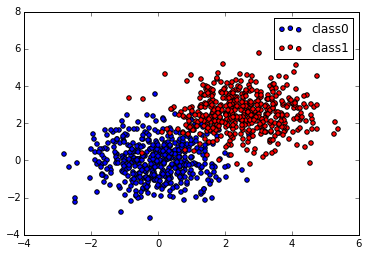

In [162]:
class0 = np.array([np.random.randn(500),np.random.randn(500)], "float32")
class1 = np.array([np.random.randn(500)+2.5,np.random.randn(500)+2.5], "float32")

plt.figure()
plt.scatter(class0[0],class0[1], label="class0")
plt.scatter(class1[0],class1[1], c="r", label="class1")
plt.legend()
plt.show()

targets = np.zeros(1000)
targets[500:1000] = 1.0
targets = np.array(targets, "float32")

trainset = np.concatenate([class0,class1], axis=1)

#### Model

In [198]:
# Declare Theano symbolic variables
x = T.matrix("x")
y = T.vector("y")
w = shared(np.random.randn(2), name="w")
b = shared(0., name="b")
print("Initial model:")
print(w.get_value())
print(b.get_value())

# Construct Theano expression graph
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))   # Probability that target = 1
prediction = p_1 > 0.5                    # The prediction thresholded
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Cross-entropy loss function
cost = xent.mean() + 0.01 * (w ** 2).sum()# The cost to minimize
gw, gb = T.grad(cost, [w, b])             # Compute the gradient of the cost
                                          # (we shall return to this in a
                                          # following section of this tutorial)

# Compile
train = function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = function(inputs=[x], outputs=prediction)

Initial model:
[ 0.70398086 -0.620114  ]
0.0


#### Training on 800 first examples

In [199]:
print "Testset score = ", sum(predict(trainset[:,800:1000].T) == targets[800:1000])/200.0

Testset score =  0.555


In [200]:
index = np.arange(800)
np.random.shuffle(index)

for i in index:
    train([trainset[:,i]],[targets[i]])

In [201]:
print "Testset score = ", sum(predict(trainset[:,800:1000].T) == targets[800:1000])/200.0

Testset score =  0.945
